# How to handle large numbers of tools

The subset of available tools to call is generally at the discretion of the model (although many providers also enable the user to [specify or constrain the choice of tool](https://python.langchain.com/docs/how_to/tool_choice/)). As the number of available tools grows, you may want to limit the scope of the LLM's selection, to decrease token consumption and to help manage sources of error in LLM reasoning.

Here we will demonstrate how to dynamically adjust the tools available to a model. Bottom line up front: like [RAG](https://python.langchain.com/docs/concepts/#retrieval) and similar methods, we prefix the model invocation by retrieving over available tools. Although we demonstrate one implementation that searches over tool descriptions, the details of the tool selection can be customized as needed.

## Setup

First, let's install the required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai numpy

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define the tools

Let's consider a toy example in which we have one tool for each company in the S&P 500 index. Each tool will fetch information, and is parameterized by a single integer representing the year.

We first construct a registry that associates a unique identifier with a schema for each tool. We will represent the tools using JSON schema, which can be bound directly to chat models supporting tool calling.

In [1]:
import re
import uuid

from langchain_core.tools import StructuredTool


def create_tool(company: str) -> dict:
    """Create schema for a placeholder tool."""
    formatted_company = re.sub(r"[^\w\s]", "", company).replace(" ", "_")

    def company_tool(year: int) -> str:
        return f"{company} had revenues of $100 in {year}."

    return StructuredTool.from_function(
        company_tool,
        name=formatted_company,
        description=f"Information about {company}",
    )


s_and_p_500_companies = [  # Abbreviated list for demonstration purposes
    "3M",
    "A.O. Smith",
    "Abbott",
    "Accenture",
    "Advanced Micro Devices",
    "Yum! Brands",
    "Zebra Technologies",
    "Zimmer Biomet",
    "Zoetis",
]

tool_registry = {
    str(uuid.uuid4()): create_tool(company) for company in s_and_p_500_companies
}

## Define the graph

### Tool selection

We will construct a node that retrieves a subset of available tools given the information in the state-- such as a recent user message. In general, the full scope of [retrieval solutions](https://python.langchain.com/docs/concepts/#retrieval) are available for this step. As a simple solution, we index embeddings of tool descriptions in a vector store, and associate user queries to tools via semantic search.

In [2]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

vector_store = InMemoryVectorStore(embedding=OpenAIEmbeddings())
document_ids = vector_store.add_documents(tool_documents)

### Incorporating with an agent

We will use a typical React agent graph (e.g., as used in the [quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-2-enhancing-the-chatbot-with-tools)), with some modifications:

- We add a `selected_tools` key to the state, which stores our selected subset of tools;
- We set the entry point of the graph to be a `select_tools` node, which populates this element of the state;
- We bind the selected subset of tools to the chat model within the `agent` node.

In [3]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]


graph_builder = StateGraph(State)

tools = list(tool_registry.values())
llm = ChatOpenAI()


def agent(state: State):
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]
    llm_with_tools = llm.bind_tools(selected_tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def select_tools(state: State):
    last_user_message = state["messages"][-1]
    query = last_user_message.content
    tool_documents = vector_store.similarity_search(query)
    return {"selected_tools": [document.id for document in tool_documents]}


graph_builder.add_node("agent", agent)
graph_builder.add_node("select_tools", select_tools)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("select_tools", "agent")
graph_builder.add_edge(START, "select_tools")
graph = graph_builder.compile()

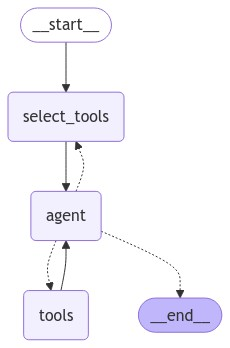

In [4]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
user_input = "Can you give me some information about AMD in 2022?"

result = graph.invoke({"messages": [("user", user_input)]})

In [6]:
print(result["selected_tools"])

['3b7d1528-6007-4473-a92f-b9b3341c3bfe', '8d77b753-c58a-41bf-9649-ad1a7326bc27', '514a6fc3-03d1-4e73-b410-c39309ad7b2f', '83c5cc8f-5111-46ed-874a-e0b883265ff6']


In [7]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you give me some information about AMD in 2022?
================================== Ai Message ==================================
Tool Calls:
  Advanced_Micro_Devices (call_Htbv7Imx4BwSsYWhZvSSs6yW)
 Call ID: call_Htbv7Imx4BwSsYWhZvSSs6yW
  Args:
    year: 2022
================================= Tool Message =================================
Name: Advanced_Micro_Devices

Advanced Micro Devices had revenues of $100 in 2022.
================================== Ai Message ==================================

In 2022, Advanced Micro Devices had revenues of $100.


## Repeating tool selection

To manage errors from incorrect tool selection, we could revisit the `select_tools` node. One option for implementing this is to modify `select_tools` to generate the vector store query using all messages in the state (e.g., with a chat model) and add an edge routing from `tools` to `select_tools`.

We implement this change below. For demonstration purposes, we simulate an error in the initial tool selection by adding a `hack_remove_tool_condition` to the `select_tools` node, which removes the correct tool on the first iteration of the node. Note that on the second iteration, the agent finishes the run as it has access to the correct tool.

<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>  

In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.pregel.retry import RetryPolicy

from pydantic import BaseModel, Field


class QueryForTools(BaseModel):
    """Generate a query for additional tools."""

    query: str = Field(..., description="Query for additional tools.")


def select_tools(state: State):
    last_message = state["messages"][-1]
    hack_remove_tool_condition = False
    if isinstance(last_message, HumanMessage):
        query = last_message.content
        hack_remove_tool_condition = True
    else:
        assert isinstance(last_message, ToolMessage)
        system = SystemMessage(
            "Given this conversation, generate a query for additional tools. "
            "The query should be a short string containing what type of information "
            "is needed. If no further information is needed, "
            "set more_information_needed False and populate a blank string for the query."
        )
        input_messages = [system] + state["messages"]
        response = llm.bind_tools([QueryForTools], tool_choice=True).invoke(
            input_messages
        )
        query = response.tool_calls[0]["args"]["query"]
    tool_documents = vector_store.similarity_search(query)
    if hack_remove_tool_condition:
        # Remove needed tool
        selected_tools = [
            document.id
            for document in tool_documents
            if document.metadata["tool_name"] != "Advanced_Micro_Devices"
        ]
    else:
        selected_tools = [document.id for document in tool_documents]
    return {"selected_tools": selected_tools}


graph_builder = StateGraph(State)
graph_builder.add_node("agent", agent)
graph_builder.add_node("select_tools", select_tools, retry=RetryPolicy(max_attempts=3))

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
)
graph_builder.add_edge("tools", "select_tools")
graph_builder.add_edge("select_tools", "agent")
graph_builder.add_edge(START, "select_tools")
graph = graph_builder.compile()

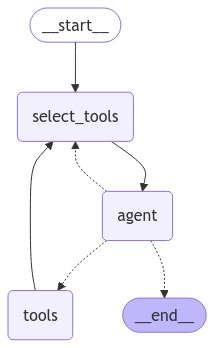

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [18]:
user_input = "Can you give me some information about AMD in 2022?"

result = graph.invoke({"messages": [("user", user_input)]})

In [19]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Can you give me some information about AMD in 2022?
================================== Ai Message ==================================
Tool Calls:
  Accenture (call_L82JRUyIFilhzeTmPnNbPeVD)
 Call ID: call_L82JRUyIFilhzeTmPnNbPeVD
  Args:
    year: 2022
================================= Tool Message =================================
Name: Accenture

Accenture had revenues of $100 in 2022.
================================== Ai Message ==================================
Tool Calls:
  Advanced_Micro_Devices (call_k3zR9zS98gjiejmNgq6aVsXL)
 Call ID: call_k3zR9zS98gjiejmNgq6aVsXL
  Args:
    year: 2022
================================= Tool Message =================================
Name: Advanced_Micro_Devices

Advanced Micro Devices had revenues of $100 in 2022.
================================== Ai Message ==================================

In 2022, Advanced Micro Devices (AMD) had revenues of $100.


## Next steps

This guide provides a minimal implementation for dynamically selecting tools. There is a host of possible improvements and optimizations:

- **Repeating tool selection**: Here, we repeated tool selection by modifying the `select_tools` node. Another option is to equip the agent with a `reselect_tools` tool, allowing it to re-select tools at its discretion.
- **Optimizing tool selection**: In general, the full scope of [retrieval solutions](https://python.langchain.com/docs/concepts/#retrieval) are available for tool selection. Additional options include:
  - Group tools and retrieve over groups;
  - Use a chat model to select tools or groups of tool.